<div class="alert alert-block alert-success">
    
# FIT5196 Assessment 3
#### Student Name: Tsz Yan CHUNG
#### Student ID: 32973381

Date: 13/10/2022


Environment: Google colab

</div>

-------------------------------------

<div class="alert alert-block alert-danger">
    
## Table of Contents

</div>    

[1. Introduction](#Intro) <br>
[2. Importing Libraries](#libs) <br>
[3. Task 1: Data Integration](#t1) <br>
$\;\;\;\;$[3.1 Solve for Suburb column](#sub) <br>
$\;\;\;\;$[3.2 Solve for closest train station id and distance](#id-dist) <br>
$\;\;\;\;$[3.3 Solve for average travel time from station to CBD](#time) <br>
$\;\;\;\;$[3.4 Check if a property is over-priced](#op) <br>
$\;\;\;\;$[3.5 Solve for average number of crime](#crime) <br>
$\;\;\;\;$[3.6 Export csv file](#write) <br>
[4. Task 2: Data Reshaping](#t2) <br>
$\;\;\;\;\;\;\;$[4.1 Normalization](#norm) <br>
$\;\;\;\;\;\;\;$[4.1.1 Z-Score Normalization](#zscore) <br>
$\;\;\;\;\;\;\;$[4.1.2 Min-max Normalization](#minmax) <br>
$\;\;\;\;\;\;\;$[4.2 Tranformation](#tran) <br>
$\;\;\;\;\;\;\;$[4.2.1 Root tranformation](#rt) <br>
$\;\;\;\;\;\;\;$[4.2.2 Power tranformation](#sq) <br>
$\;\;\;\;\;\;\;$[4.2.3 Log tranformation](#log) <br>
[4.3. Conclusion](#conclude) <br>


-------------------------------------

<div class="alert alert-block alert-warning">

## 1.  Introduction  <a class="anchor" name="Intro"></a>
    
</div>

Two major tasks will be performed in this assessment:

1. Data Integration
2. Data Reshaping

These tasks will be performed separately, while some of them might provide insight in other tasks.

This notebook aims to demonstrate the methodology to achieve the correct result.

** Note to audience:
In step 3.1, a zip file has to be extracted to conducted certain task. The directory is set to be my drive, which might not be accessible to everyone. Please remeber to change to extract directory before running the code, so that the whole ipynb file could run properly. 

Also in step 3.1, one of the codes might take up to 2 minutes to run, you patience is really appreciated.

-------------------------------------

<div class="alert alert-block alert-warning">
    
## 2. Import Libraries, set up directories, and parse data  <a class="anchor" name="libs"></a>
 </div>

In [1]:
# import libraries
!pip install geopandas
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime as dt
from zipfile import ZipFile
from shapely.geometry import Point, Polygon, shape
from geopandas.tools import sjoin
from math import radians, cos, sin, atan2, sqrt, asin
from sklearn import preprocessing
import datetime
from tqdm import tqdm
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# This task was conducted on Google colab
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set up directories

os.chdir("/content/drive")
os.getcwd()

'/content/drive'

In [4]:
# Read data file
df = pd.read_csv("Shareddrives/FIT5196-s2-2022/A3/student_data/32973381.csv")

It was noticed that the data file contains duplicate rows. These rows will be removed from the data frame. 
There were 39 rows dropped after such process, and 681 unique rows of data remain in the dataset.

In [5]:
# remove duplicated values

df[df.duplicated()]
df = df.drop_duplicates()
df = df.reset_index(drop = True)

For further operation and data wrangling process, the rest of the required files were read in advanced.

In [6]:
# Comabine routes.txt files
routes1 = pd.read_csv("/content/drive/Shareddrives/FIT5196-s2-2022/A3/gtfs/1/routes.txt")
routes2 = pd.read_csv("/content/drive/Shareddrives/FIT5196-s2-2022/A3/gtfs/2/routes.txt")
routes = pd.concat([routes1, routes2])

# Comabine trips.txt files
trips1 = pd.read_csv("/content/drive/Shareddrives/FIT5196-s2-2022/A3/gtfs/1/trips.txt")
trips2 = pd.read_csv("/content/drive/Shareddrives/FIT5196-s2-2022/A3/gtfs/2/trips.txt")
trips = pd.concat([trips1, trips2])

# Comabine stop_times.txt files
stop_time1 = pd.read_csv("/content/drive/Shareddrives/FIT5196-s2-2022/A3/gtfs/1/stop_times.txt")
stop_time2 = pd.read_csv("/content/drive/Shareddrives/FIT5196-s2-2022/A3/gtfs/2/stop_times.txt")
stop_time = pd.concat([stop_time1, stop_time2], ignore_index = True)

# Comabine calendar.txt files
calendar1 = pd.read_csv("/content/drive/Shareddrives/FIT5196-s2-2022/A3/gtfs/1/calendar.txt")
calendar2 = pd.read_csv("/content/drive/Shareddrives/FIT5196-s2-2022/A3/gtfs/2/calendar.txt")
calendar = pd.concat([calendar1, calendar2], ignore_index = True)

# Comabine shapes.txt files
shapes1 = pd.read_csv("/content/drive/Shareddrives/FIT5196-s2-2022/A3/gtfs/1/shapes.txt")
shapes2 = pd.read_csv("/content/drive/Shareddrives/FIT5196-s2-2022/A3/gtfs/2/shapes.txt")
shapes = pd.concat([shapes1, shapes2])

# Comabine stops.txt files
train_stops1 = pd.read_csv("/content/drive/Shareddrives/FIT5196-s2-2022/A3/gtfs/1/stops.txt")
train_stops2 = pd.read_csv("/content/drive/Shareddrives/FIT5196-s2-2022/A3/gtfs/2/stops.txt")
train_stops = pd.concat([train_stops1, train_stops2])

-------------------------------------

<div class="alert alert-block alert-warning">

## 3. Task 1: Data Intergration<a class="anchor" name="t1"></a>
    
</div>

In this task, I will integrate several datasets into a single accroding to the instruction, and create a csv output file in the end of the task.

<div class="alert alert-block alert-warning">
    
## 3.1 Solve for Suburb column <a class="anchor" name="sub"></a>
 </div>

To derive suburb values for each record, read suburb boundary "shp" file from zip flie

Methodology:
1. From the dataset, each property is provided with a coordinates of Latitude and Longitide values. With these value, a point could be form accordingly.

2. Meanwhile, A shp file is provided, which is the map of VIC suburb boundary. This boundaries are basically lists of point, indicating a "polygon" on the map.

3. By matching each "point" to "polygon", we can use the function in geopandas library: within, or contain to check if a point is within a polygon (or if a polygon contains the point). In the codes below, the within method was adopted.

4. Once a polygon is matched, the name of the suburb could be referred to from the shp file provided.


In [7]:
# Extract file, and read shp file
# Here I used my own directory to extract Zip file, please change directory before you run the code

with ZipFile("/content/drive/Shareddrives/FIT5196-s2-2022/A3/vic_suburb_boundary.zip", "r") as zObject:
  zObject.extractall(path = "/content/drive/MyDrive/5196A3")

gdf = gpd.read_file("/content/drive/MyDrive/5196A3/VIC_LOCALITY_POLYGON_shp.shp")

In [8]:
# Get geometry values from student_data.csv (df) and from the suburb boundary value
geopoint = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longtitude, df.Lattitude))
geopoly = gpd.GeoDataFrame(gdf, geometry = gdf.geometry)

In [9]:
# For each single point (a point with coordinates: lat, lon), find the region that contains that single point
# (run time: 1 minutes 43 seconds)
sub = []
for i, v in geopoint.iterrows():
  for idx, val in geopoly.iterrows():
    if v.geometry.within(val.geometry):
      sub.append(val.VIC_LOCA_2.title())
      break

In [10]:
# Add suburb list to the dataframe

df["Suburb"] = sub

-------------------------------------

<div class="alert alert-block alert-warning">
    
## 3.2 Solve for Train station ID and closest distance to train station (with direct trip to Southern Cross Station) <a class="anchor" name="id-dist"></a>
 </div>

In the next step, both train station ID and closest distancce to train station would be solved. Due to the methodology I applied, the method to finding them both will be performed almost simultaneously, therefore these two attributes are combined here together.



In [11]:
# Find services that work on all weekdays (Mon - Fri)
s_id = calendar[(calendar["monday"] == 1) & (calendar["tuesday"] == 1) & (calendar["wednesday"] == 1) & (calendar["thursday"] == 1) & (calendar["friday"] == 1)].service_id

# Find all trips that works on all weekdays: 
all_trips = stop_time.loc[stop_time.trip_id.str.contains(('|'.join(s_id)))]


In [12]:
# Create stop_dict dictionary that uses key as train_station_id, and contains the station coordinates (values)
stop_dict = {}
for idx, val in train_stops.iterrows():
  stop_dict[val.stop_id] = val.stop_lon, val.stop_lat

From all_trips created from the codes above, they will be further filter according to their departure time. 
All trips which are departed during the weekday within time range of 0700 to 0930 will be filtered, and save as a new dataframe: "weekday_trip"

In [13]:
time_format = "%H:%M:S" #set up time format
weekday_idx = []
error_list = []
for idx, val in all_trips.iterrows():
  try:
    # apply time format
    if dt.strptime(val.departure_time, "%H:%M:%S") <= dt.strptime("09:30:00", "%H:%M:%S") and dt.strptime(val.departure_time, "%H:%M:%S") >= dt.strptime("07:00:00", "%H:%M:%S"):
      weekday_idx.append(idx)
  # Stpre errpr values
  except ValueError:
    error_list.append(idx)

# dt.strptime(all_trips.loc[578, "departure_time"], "%H:%M:%S") < dt.strptime("07:00:00", "%H:%M:%S")
weekday_trip = all_trips.loc[weekday_idx,]

It was also noticed that there were some error datetime value when performing such comparison.
The error values were found out, and they all have time values exceeded the standard 00:00 to 23:59 time range.

As it was uncertain if the errors were due to mechancial malfunctions or mannual data entry mistakes, those records were removed from the calculation process to maintain accuracy.

In [14]:
# error values
all_trips.loc[error_list].departure_time

5050      24:04:00
5051      24:17:00
5052      24:33:00
5053      24:42:00
5056      24:23:00
            ...   
541674    25:36:00
541679    26:33:00
541680    26:35:00
541681    26:37:00
541682    26:39:00
Name: departure_time, Length: 2779, dtype: object

In [15]:
# Get train_station id of Southern Cross station
scs_id = train_stops[train_stops.stop_name.str.contains("Southern Cross")]["stop_id"]


The codes below is trying to achieve two things:
1. Get the train_station that is the closest to the property while having direct trip to the Southern Corss Station (train_station_id)

2. Get distance (Haversine distance) from that closest train station, with direct trip to Southern Cross Station, to the property. (distance_to_train_station)


Methodology:
1. Firstly, I created a loop to go through all the properties in df dataframe one by one, getting their coordinates from the Lat, Long values from the data, and convert it into radian value

2. After that, I get coordinates of all train station. With coordinates of two points both obtaine, the Haversine distance calculation could be conducted and obtain the Haversine distance.

3. By obtaining a list of Haversine distance, all values could then be compared, I derive the smallest number (shortest distance), and use the dictionary created to match with the train station ID.

4. With the train station ID, I could check with the trips data and see if the train station has direct trip to the Southern Cross Station. If it has direct trip to Southern Cross Station, it will be stored as the final output, otherwise, I will look for the second closest train statino and repeat the process.

In [16]:
# Set up parameters for calculation purpose
r = 6378
closest_train_stop = []
distance = []

# Begin loop with all properties
for idx, row in df.iterrows():

  # Create emtpy contrainers to store desired value
  dist_dict = {}   # Dictionary, store distance (key) corresponding to train station ID (value 
  dist_dict2 = {}  # Reverse dictionary of dist_dict
  dist_list = []   # A handle to compare distance from property to train stations

  # Start Haversine distance calculation
  lon1 = radians(row.Longtitude) #Longitude coordinate of property
  lat1 = radians(row.Lattitude)  #Latitude coordinate of property

  # Create 2nd loop in stop_dict dictionary
  for key, val in stop_dict.items():
    lon2 = radians(val[0]) #Train station Longitude coordinate
    lat2 = radians(val[1]) #Train station Latitude coordinate

    dlon = (lon2 - lon1)  # Get difference in Longitude
    dlat = (lat2 - lat1)  # Get difference in Latitude

    # Haversine distance formula
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    dist = r * c  # Haversine distance obtained
    # end of Haversine distance calculation

    dist_list.append(dist)  # add calculated distance to handle
    dist_dict[dist] = key   # add dictionary pairs of distance to train station ID
    dist_dict2[key] = dist  

  # Create while loop
  n = 0
  right_df = weekday_trip[weekday_trip.stop_id.isin(scs_id)]  # df of trips of Southern Cross station
  while n in range(len(dist_list)):
    # Get shortest distance from all train station to property,
    # by getting the first station from a sorted list
    closest_dist = sorted(dist_list)[n]

    # Create df of trips about the closest train station, and merge it with the df of trips of Southern Cross station by "trip_id" 
    left_df = weekday_trip[weekday_trip["stop_id"] == dist_dict[closest_dist]]
    merged_df = left_df.merge(right_df, on = "trip_id", how = "inner")
    
    # If they are successfully merged, and stop_sequence number at Southern Cross Station is larger than that of the train station,
    # it represents there are direct trip from the train station to Southern Cross Station
    if len(merged_df[merged_df["stop_sequence_x"] < merged_df["stop_sequence_y"]]) > 0:
      # Store train station ID as closest train stop
      closest_train_stop.append(dist_dict[closest_dist])
      # Store distance value of this closest train stop
      distance.append(closest_dist)
      # print(len(closest_train_stop))
      break
    # Otherwise, there are no direct trip from the train station to Southern Cross station
    # Look for the next closest train station and repeat.
    else:
      n += 1

In [17]:
# Add the two attributes to dataframe
df["train_station_id"] = closest_train_stop
df["distance_to_train_station"] = distance

-------------------------------------

<div class="alert alert-block alert-warning">

## 3.3.  Get travel_min_to_CBD  <a class="anchor" name="time"></a>
    
</div>

By applying a simlar method I used for train station and distance, the travel time from a station to the Southern Cross Station could also be obtained.

In [18]:
# Create empty handle for time
avg_time = []
for n in range(len(closest_train_stop)):
  travel_time = []
  # We want to check the travel time from the list of closest train station to Southern Cross Station
  # check for trips that match those IDs
  left_df = weekday_trip[weekday_trip["stop_id"] == closest_train_stop[n]]
  
  # right_df is all trips of Southern Cross Station
  right_df = weekday_trip[weekday_trip.stop_id.isin(scs_id)]

  # Merge two dataframe, if stop sequence in right_df is larger then that of left_df, it means the trip is from the targeted train station towards Southern Cross Station
  merged_df = left_df.merge(right_df, on = "trip_id", how = "inner")
  merged_df = (merged_df[merged_df["stop_sequence_x"] < merged_df["stop_sequence_y"]])

  # Get the difference between departure time from the starting station and arrival time at the Southern Cross Station
  for idx, val in merged_df.iterrows():
    travel_time.append(dt.strptime(val.arrival_time_y, "%H:%M:%S") - dt.strptime(val.departure_time_x, "%H:%M:%S"))
  # As there are more than one trips during that period, the time difference obtained will be a list.
  # Get the sum of list and divide it by the number of trips would result in the average time
  avg_time.append((sum(travel_time, datetime.timedelta()).total_seconds())/len(travel_time)/ 60)



In [19]:
# Store average travel time obtained into dataframe
df["travel_min_to_CBD"] = avg_time

-------------------------------------

<div class="alert alert-block alert-warning">

## 3.4  Determine if the property is over-priced  <a class="anchor" name="op"></a>
    
</div>

In the next task, each property will be evaluated if it is over-priced or not by taking the Median of all properties with the same set of attributes. As instructed, the set of attributes is:

1. Number of bedrooms
2. Number of Bathrooms
3. Number of parking spaces
4. Property type
5. Suburb
6. Year of selling


In [20]:
# Get year of selling and add to Dataframe
df_year = pd.to_datetime(df.Date).dt.year
df["Year"] = df_year

In [21]:
# Apply groupby function and get the median value
median = df.groupby(["Rooms", "Bathroom", "Car", "Type", "Suburb", "Year"])["Price"].median()

In [22]:
# Merged median dataframe and df
combined = df.merge(median, how = "left", on = ["Rooms", "Bathroom", "Car", "Type", "Suburb", "Year"])

# Assign "over_price?" boolean value
for idx, row in combined.iterrows():
  if row.Price_x > row.Price_y:
    combined.loc[idx,"over_priced?"] = True
  else:
    combined.loc[idx,"over_priced?"] = False

df["over_priced?"] = combined["over_priced?"]

-------------------------------------

<div class="alert alert-block alert-warning">

## 3.5  Get average Crime numbers  <a class="crime" name="crime"></a>
    
</div>

We were provided with a text file and excel file to find the crime number in a specific council.

In [23]:
# read excel that contains crime data
excel_data = pd.ExcelFile("/content/drive/Shareddrives/FIT5196-s2-2022/A3/crimebylocation.xlsx")
sheet = excel_data.sheet_names[-1]  # Knowing there are two sheets, only the second sheet is useful for this task
excel = excel_data.parse(sheet)

In [24]:
# Parsing excel file
excel = excel.drop(["Unnamed: 0"], axis = 1)
excel = excel.dropna(0, how = "all")
excel = excel.dropna(1, how = "all")
excel.index = range(len(excel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  after removing the cwd from sys.path.


In [25]:
# Continue parsing file
excel.iloc[1, 0] = "Year"
excel.rename(columns = excel.iloc[1], inplace = True)
excel = excel.drop(excel.index[0:2])
excel.reset_index(inplace = True, drop = True)

In [26]:
# Inspect excel file
excel

,Year,Police Region,Police Service Area,Local Government Area,CSA Offence Division,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP
0,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A10 Homicide and related offences,4,123600,5632521
1,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A20 Assault and related offences,568,123600,5632521
2,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A30 Sexual offences,132,123600,5632521
3,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A40 Abduction and related offences,12,123600,5632521
4,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A50 Robbery,46,123600,5632521
...,...,...,...,...,...,...,...,...,...
9080,2016,4 Western,WARRNAMBOOL,WARRNAMBOOL,E Justice procedures offences,E10 Justice procedures,79,33795,6053355
9081,2016,4 Western,WARRNAMBOOL,WARRNAMBOOL,E Justice procedures offences,E20 Breaches of orders,360,33795,6053355
9082,2016,4 Western,WARRNAMBOOL,WARRNAMBOOL,F Other offences,F20 Transport regulation offences,2,33795,6053355
9083,2016,4 Western,WARRNAMBOOL,WARRNAMBOOL,F Other offences,F30 Other government regulatory offences,4,33795,6053355


In [27]:
# By inspecting the excel file, it is known that each crime is categorized in to type A to type F.
# In this task, only type A, B, and C are wanted

# Create new column for crime type
for idx, row in excel.iterrows():
  excel.loc[idx, "Crime Type"] = (row["CSA Offence Subdivision"][0])

In [28]:
# Filter dataset to crime types that we are interested in 
types = ["A", "B", "C"]
excel = excel[excel["Crime Type"].isin(types)]

Moreover, the task does not require the details of the crime, but only the count of crime types within a specific region (Properties' suburb).

In [29]:
# Use the groupby function to group crimes by their "Crime type", "Year of incidence", "Area" that the crime took place.
crime_grouped = excel.groupby(["Year", "Crime Type", "Local Government Area"])["Offence Count"].sum().reset_index()

In [30]:
crime_grouped

,Year,Crime Type,Local Government Area,Offence Count
0,2012,A,ALPINE,72
1,2012,A,ARARAT,217
2,2012,A,BALLARAT,1652
3,2012,A,BANYULE,987
4,2012,A,BASS COAST,430
...,...,...,...,...
1179,2016,C,WODONGA,162
1180,2016,C,WYNDHAM,648
1181,2016,C,YARRA,955
1182,2016,C,YARRA RANGES,570


In [31]:
# Call for another helpful file 
council_df = pd.read_csv("/content/drive/Shareddrives/FIT5196-s2-2022/A3/councils.txt", sep = ":", header = None)
council_df.columns = ["Council", "Suburbs"]

for idx, row in council_df.iterrows():
  council_df.loc[idx, "Suburbs"] = row.Suburbs.upper()

council.txt is a text file seprated with colon. It contains value of suburbs, and the in charge council for each suburb.
By using this txt file, we could refer to the df dataframe, where only "suburb" value is included, to their in charge council. Such that we could comopute for the average number of crime in the council area.

In [32]:
for idx, row in df.iterrows():
  # We are interested in the last 3 years of record before the property purchase date (i.e. not including purchase year)
  record = []
  record.append(row.Year -1)
  record.append(row.Year -2)
  record.append(row.Year -3)

  sub = row.Suburb.upper()   # Recall suburb values computed earlier
  # Finding council in charge for the subrub according to the text file
  council= council_df.loc[council_df["Suburbs"].str.contains(sub)]["Council"].values[0].strip()
  # Create subset from crime file, where the years match the last 3 years of the property purchase data
  # and the council is the one in charge for the property suburb
  subset = crime_grouped.loc[(crime_grouped["Year"].isin(record)) & (crime_grouped["Local Government Area"] == council)]
  subset = subset.groupby(["Crime Type"])["Offence Count"].mean()
  # Store value according the crime type A, B, or C
  df.loc[idx, "crime_A_average"] = subset["A"]
  df.loc[idx, "crime_B_average"] = subset["B"]
  df.loc[idx, "crime_C_average"] = subset["C"]

-------------------------------------

<div class="alert alert-block alert-warning">

## 3.6 Export csv files <a class="anchor" name="write"></a>
    
</div>

In [33]:
# and now the df file is almost ready with all the attributes found
df

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,geometry,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD,Year,over_priced?,crime_A_average,crime_B_average,crime_C_average
0,ID220474863,4/8 Bevan St,2,u,614000.0,12/08/2017,1.0,1.0,0.0,79.0,...,POINT (145.07468 -37.81303),Balwyn,19893,1.398997,23.818182,2017,True,959.000000,4476.666667,324.000000
1,ID742726415,46 Chapel St,3,h,1000000.0,15/07/2017,1.0,1.0,198.0,69.0,...,POINT (144.99104 -37.86566),St Kilda,19956,0.478276,17.500000,2017,False,1412.000000,6364.000000,699.333333
2,ID834037259,3/37 Atkins St,2,t,672000.0,17/09/2016,1.0,1.0,0.0,39.0,...,POINT (145.04460 -37.80940),Kew,19903,1.451061,18.000000,2016,False,271.666667,771.666667,74.000000
3,ID303125007,44 Milton Pde,3,h,780000.0,3/06/2017,1.0,1.0,546.0,129.0,...,POINT (145.06463 -37.69388),Bundoora,19984,2.542187,37.461538,2017,False,684.000000,1695.666667,161.000000
4,ID213024439,4/605 High St,2,u,630000.0,20/05/2017,1.0,1.0,0.0,49.0,...,POINT (145.00880 -37.85380),Prahran,19946,0.561337,18.384615,2017,False,705.333333,5479.666667,335.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,ID800631788,805/300 Swanston St,2,u,665000.0,7/11/2016,1.0,1.0,0.0,15.0,...,POINT (144.96460 -37.81060),Melbourne,19842,0.191196,4.722543,2016,False,278.000000,489.000000,65.000000
677,ID529751296,2/953 High St,2,h,555000.0,11/02/2017,1.0,2.0,229.0,49.0,...,POINT (145.00820 -37.71000),Reservoir,20009,0.261188,35.111111,2017,False,885.000000,1901.000000,227.666667
678,ID119745776,7 Rosshire Rd,3,h,776000.0,12/11/2016,1.0,3.0,363.0,49.0,...,POINT (144.86730 -37.84760),Newport,19994,1.532443,16.346154,2016,False,71.000000,261.000000,20.000000
679,ID521269741,22 Stewart St,2,h,1140000.0,3/12/2016,1.0,0.0,230.0,19.0,...,POINT (145.05500 -37.82260),Hawthorn East,19853,0.548363,19.214286,2016,False,1144.333333,6845.666667,375.666667


In [34]:
# Drop "Year" column in the dataframe
df = df.drop(["Year"], axis = 1)

In [35]:
# Create output df and re-arrange columns order
output = df[["ID", "Address", "Rooms", "Type", "Price", "Date", "Bathroom", "Car", "Landsize", "Age", "Lattitude", "Longtitude", "Suburb", "train_station_id", "distance_to_train_station", "travel_min_to_CBD", "over_priced?", "crime_A_average", "crime_B_average", "crime_C_average"]]

In [36]:
# Exportt as csv file
os.chdir("/content/drive/MyDrive/5196A3")
output.to_csv("32973381_solution.csv", index = False)

-------------------------------------

<div class="alert alert-block alert-warning">

## 4. Task 2: data reshaping  <a class="anchor" name="t2"></a>
    
</div>

In [37]:
# Select and observe the instructed estimators and output
df[["Rooms", "crime_C_average", "travel_min_to_CBD", "Age", "Price"]].describe()

,Rooms,crime_C_average,travel_min_to_CBD,Age,Price
count,681.000000,681.000000,681.000000,681.000000,6.810000e+02
mean,2.972100,431.281449,26.361920,55.447871,1.083457e+06
std,0.947497,406.434945,11.035975,46.257597,6.535910e+05
min,1.000000,1.000000,3.176471,2.000000,2.160000e+05
25%,2.000000,159.333333,19.384615,22.000000,6.750000e+05
50%,3.000000,335.000000,25.933333,49.000000,9.100000e+05
75%,4.000000,564.333333,32.416667,79.000000,1.350000e+06
max,7.000000,2042.333333,68.666667,823.000000,6.400000e+06


As observed from the tables above, if the four attributes:
"Rooms", "crime_C_average", "travel_min_to_CBD", and "Age" are required to put into a linear model on predicting the price value, they result could be biased due to their difference in scale.

Rooms: values ranged from 1 to 7, which is the normal number of room number a property has

crime_C_average: number of crime throughout a whole year (average of 3 years), which is supposed to be a lot larger than the number of rooms a property has.

travel_min_to_CBD: time values measured in minutes, which ranged from 3 minutes to 68 minutes.

Age: Age of property ranged from the smallest number 2 to the largest 823.

Bias in model could be caused by their difference in scale applied.

-------------------------------------

<div class="alert alert-block alert-warning">

## 4.1 Normalization  <a class="anchor" name="norm"></a>
    
</div>

<div class="alert alert-block alert-warning">

## 4.1.1 Z-Score Normalization  <a class="anchor" name="zscore"></a>
    
</div>

The first normalization method to perform is the Z-score normalization method. The aim of this method is to convert the original data into a standard normal distribution with mean of 0 and variance of 1.

The benefit of this is that all attributes will be based on the same scale after such normalization process.

In [38]:
# Get desired attributes for linear model
df_copy = df[["crime_C_average", "Rooms", "travel_min_to_CBD", "Age", "Price"]]
# Apply normalization
std_scale = preprocessing.StandardScaler().fit(df_copy[["crime_C_average", "Rooms", "travel_min_to_CBD", "Age", "Price"]])
df_std = std_scale.transform(df[["crime_C_average", "Rooms", "travel_min_to_CBD", "Age", "Price"]])

In [39]:
df_copy["scaled_crime"] = df_std[:,0]
df_copy["scaled_rooms"] = df_std[:,1]
df_copy["scaled_time"] = df_std[:,2]
df_copy["scaled_age"] = df_std[:,3]
df_copy["scaled_p"] = df_std[:,4]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [40]:
df_copy.describe()

,crime_C_average,Rooms,travel_min_to_CBD,Age,Price,scaled_crime,scaled_rooms,scaled_time,scaled_age,scaled_p
count,681.000000,681.000000,681.000000,681.000000,6.810000e+02,6.810000e+02,6.810000e+02,6.810000e+02,6.810000e+02,6.810000e+02
mean,431.281449,2.972100,26.361920,55.447871,1.083457e+06,1.252058e-16,-7.825361e-18,1.988946e-16,2.347608e-17,1.017297e-16
std,406.434945,0.947497,11.035975,46.257597,6.535910e+05,1.000735e+00,1.000735e+00,1.000735e+00,1.000735e+00,1.000735e+00
min,1.000000,1.000000,3.176471,2.000000,2.160000e+05,-1.059451e+00,-2.082909e+00,-2.102441e+00,-1.156289e+00,-1.328192e+00
25%,159.333333,2.000000,19.384615,22.000000,6.750000e+05,-6.695979e-01,-1.026721e+00,-6.326974e-01,-7.236099e-01,-6.254014e-01
50%,335.000000,3.000000,25.933333,49.000000,9.100000e+05,-2.370668e-01,2.946781e-02,-3.886394e-02,-1.394930e-01,-2.655851e-01
75%,564.333333,4.000000,32.416667,79.000000,1.350000e+06,3.276039e-01,1.085656e+00,5.490405e-01,5.095258e-01,4.081136e-01
max,2042.333333,7.000000,68.666667,823.000000,6.400000e+06,3.966775e+00,4.254222e+00,3.836167e+00,1.660519e+01,8.140337e+00


With this normalization, the selected attributes now have statistical inference: mean and variance very close to 0 and 1 respectively.

In [41]:
%matplotlib inline

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbfa29f5650>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbfa29f5650>)

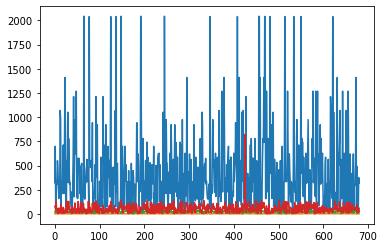

In [42]:
# Before normalization, the distribution of all attributes look like this
df_copy["crime_C_average"].plot(), df_copy["Rooms"].plot(), df_copy["travel_min_to_CBD"].plot(), df_copy["Age"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbfa14284d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbfa14284d0>)

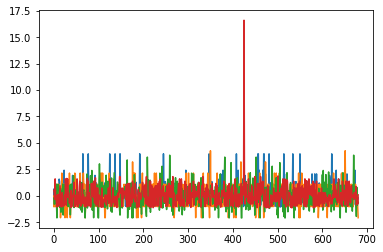

In [43]:
# After normalization process, data are clearly mroe centralizaed and clustered
df_copy["scaled_crime"].plot(), df_copy["scaled_rooms"].plot(), df_copy["scaled_time"].plot(), df_copy["scaled_age"].plot()

Which the normalization process bring all attributes into the same scale, while maintaining their original distribution (shape of line).
Let's look into each attribute individually

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbfa20825d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbfa20825d0>)

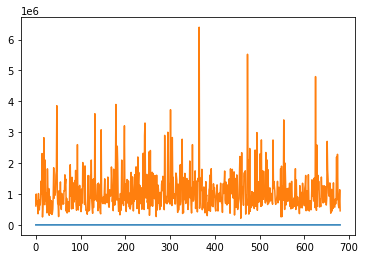

In [44]:
# Crime data and price of property, before normalization
df_copy["crime_C_average"].plot(), df_copy["Price"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbfa1467e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbfa1467e10>)

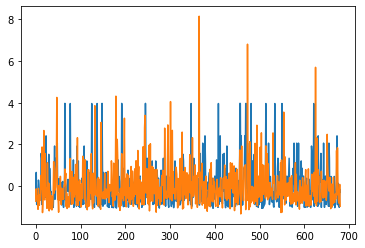

In [45]:
# Crime data and price of property, after normalization
df_copy["scaled_crime"].plot(), df_copy["scaled_p"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbfa15e23d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbfa15e23d0>)

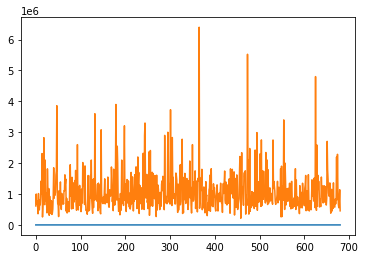

In [46]:
# Rooms data, before normalization
df_copy["Rooms"].plot(), df_copy["Price"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbfa0ec8050>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbfa0ec8050>)

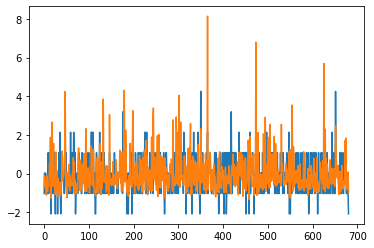

In [47]:
# Rooms data, after normalization
df_copy["scaled_rooms"].plot(), df_copy["scaled_p"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbfa0e3f2d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbfa0e3f2d0>)

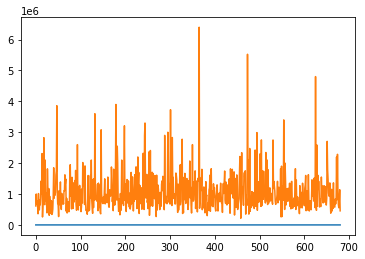

In [48]:
# Travel time against price, before normalization
df_copy["travel_min_to_CBD"].plot(), df_copy["Price"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbfa0e2bbd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbfa0e2bbd0>)

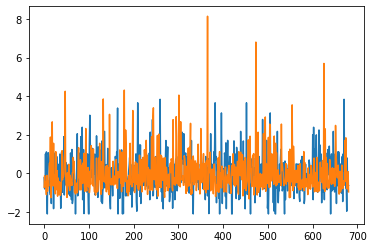

In [49]:
# Travel time against price, after normalization
df_copy["scaled_time"].plot(), df_copy["scaled_p"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbfa0e1fb10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbfa0e1fb10>)

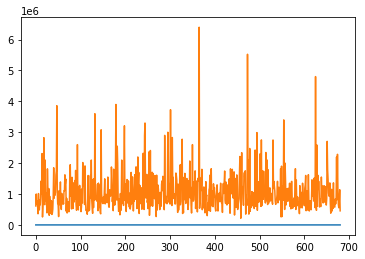

In [50]:
# Age data, before normalization
df_copy["Age"].plot(), df_copy["Price"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbfa0dad350>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbfa0dad350>)

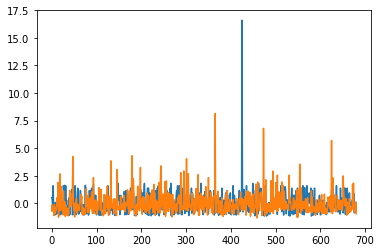

In [51]:
# Age data, after normalization
df_copy["scaled_age"].plot(), df_copy["scaled_p"].plot()

-------------------------------------

<div class="alert alert-block alert-warning">

## 4.1.2 Min-max normalization  <a class="anchor" name="minmax"></a>
    
</div>

The second practice applied is the Min-max normalization method.
Compared to the Z-score normlization method that adopts to converting the whole distribution to a standard normal distribution with mean of 0 and variance of 1, and scaled upon their standard deviation value of each row, the min-max method uses another practise.

It uses the maximum and minimum value of attributes in the selected dataset, and uses the max value and min value to form the scale of max of 1 and minimum of 0.

The whole process could be done also with the sklearn preprocessing library:

In [52]:
# apply normalization
minmax_scale = preprocessing.MinMaxScaler().fit(df_copy[["crime_C_average", "Rooms", "travel_min_to_CBD", "Age", "Price"]])
df_minmax = minmax_scale.transform(df[["crime_C_average", "Rooms", "travel_min_to_CBD", "Age", "Price"]])


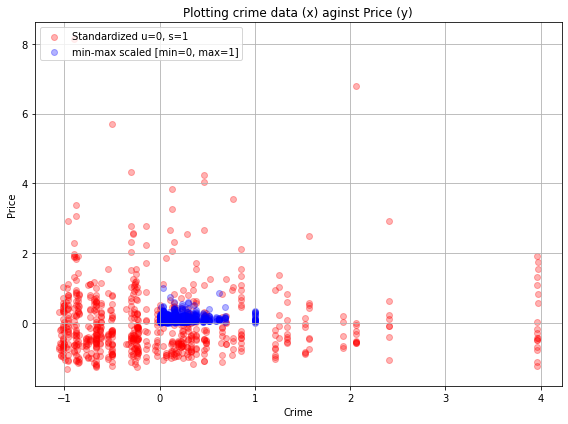

In [53]:
# Plot of number of crime against price
# Red dots represents the Z-Score normalization while blue dots represents the Min-max normalization
%matplotlib inline

from matplotlib import pyplot as plt

def plot():
    f = plt.figure(figsize=(8,6))
    plt.scatter(df_std[:,0], df_std[:,4], color='red',
             label='Standardized u=0, s=1', alpha=0.3)
    
    plt.scatter(df_minmax[:,0], df_minmax[:,4],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.title('Plotting crime data (x) aginst Price (y)')
    plt.xlabel('Crime')
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()

plot()
plt.show()

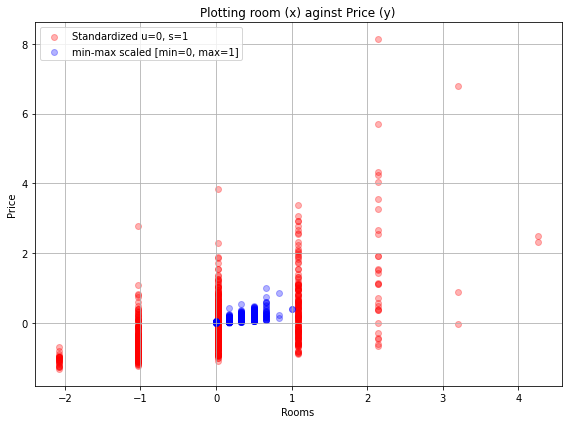

In [54]:
# Plot of number of rooms against price
# Red dots represents the Z-Score normalization while blue dots represents the Min-max normalization
%matplotlib inline

from matplotlib import pyplot as plt

def plot():
    f = plt.figure(figsize=(8,6))

    plt.scatter(df_std[:,1], df_std[:,4], color='red',
             label='Standardized u=0, s=1', alpha=0.3) 
    
    plt.scatter(df_minmax[:,1], df_minmax[:,4],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.title('Plotting room (x) aginst Price (y)')
    plt.xlabel('Rooms')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()


plot()
plt.show()

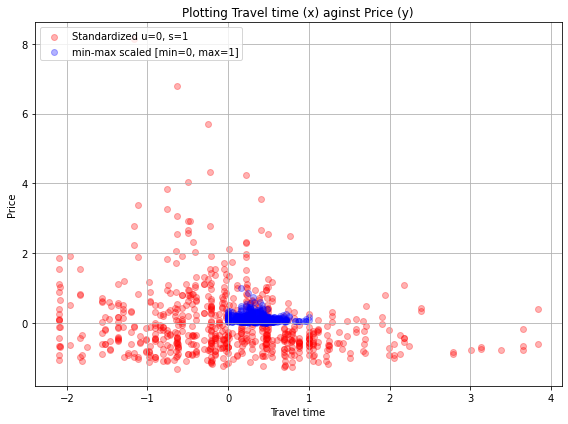

In [55]:
# Plot of travel time against price
# Red dots represents the Z-Score normalization while blue dots represents the Min-max normalization
%matplotlib inline

from matplotlib import pyplot as plt

def plot():
    f = plt.figure(figsize=(8,6))
    plt.scatter(df_std[:,2], df_std[:,4], color='red',
             label='Standardized u=0, s=1', alpha=0.3)
    
    plt.scatter(df_minmax[:,2], df_minmax[:,4],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.title('Plotting Travel time (x) aginst Price (y)')
    plt.xlabel('Travel time')
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()

plot()
plt.show()

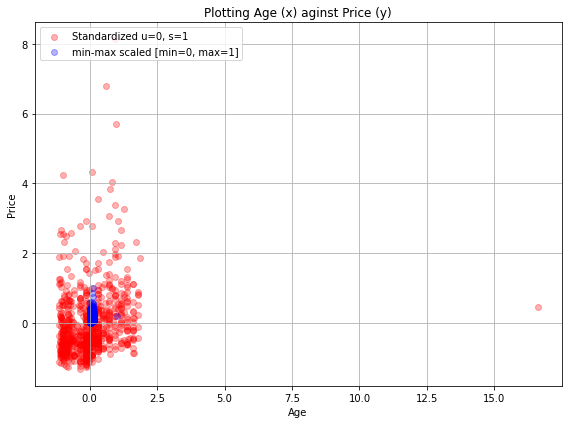

In [56]:
# Plot of properties' age against price
# Red dots represents the Z-Score normalization while blue dots represents the Min-max normalization
%matplotlib inline

from matplotlib import pyplot as plt

def plot():
    f = plt.figure(figsize=(8,6))
    plt.scatter(df_std[:,3], df_std[:,4], color='red',
             label='Standardized u=0, s=1', alpha=0.3)
    
    plt.scatter(df_minmax[:,3], df_minmax[:,4],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.title('Plotting Age (x) aginst Price (y)')
    plt.xlabel('Age')
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()

plot()
plt.show()

Normalization conclusion:

From the above transformation, it was noticed that the min-max normalization (blue dots) results in significant lower biasness when compared to the Z-score normalization.

As it is shown on graph, blue dots are clustered for all of the graph while the red dots are relatively scattered around the plot. 

This is mainly because the min-max method limits the range of all value within 0 and 1; while the Z-score normalization method maintain mean value as 0 and variance as 1, but it allows the outliers to exist and be reflected on visualization.

There are outliers that exist in the dataset, and they are observations that might provide valuable information if a linear model has to be built upon the selected attributes.

In such case, I believe the Z-score normalization will be a more suitable practice to be applied on such dataset among the two.

-------------------------------------

<div class="alert alert-block alert-warning">

## 4.2 Data transformation  <a class="anchor" name="tran"></a>
    
</div>

In the following cells, three data transformation will be applied to see the change in relations between the estimators, and the output.
The three methods include:
1. Root-transformation
2. Squared-transformation
3. Log-transformation

In [57]:
# Get estimate and output
df_copy = df[["crime_C_average", "Rooms", "travel_min_to_CBD", "Age", "Price"]]


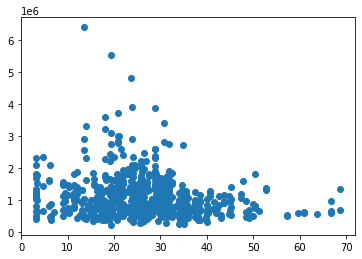

In [58]:
# plot travel time aginst price before transformation
plt.scatter(df_copy.travel_min_to_CBD, df_copy.Price)

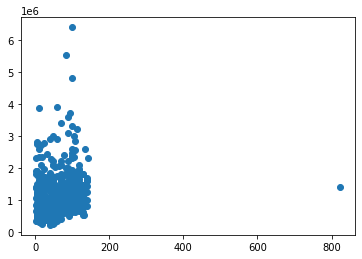

In [59]:
# plot age aginst price before transformation
plt.scatter(df_copy.Age, df_copy.Price)


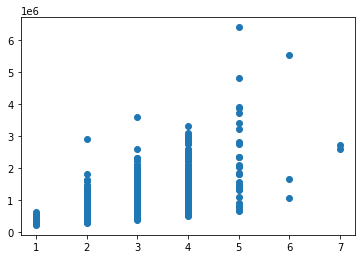

In [60]:
# plot number of rooms aginst price before transformation
plt.scatter(df_copy.Rooms, df_copy.Price)


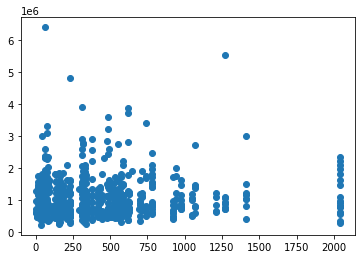

In [61]:
# plot crime data aginst price before transformation

plt.scatter(df_copy.crime_C_average, df_copy.Price)


From the above graphs, we cannot observed strong relationship between the individual estimator to the output.

Now, let's discover the effect after performing transformation.

-------------------------------------

<div class="alert alert-block alert-warning">

## 4.2.1 Root Transformation <a class="anchor" name="rt"></a>
    
</div>

The root transformation takes root (squared-root in this example) of the whole dataset. The transformation aims to return a linear relationship between an estimator and output.

In [62]:
# apply squared-root to both estimators and output

df_copy = df[["crime_C_average", "Rooms", "travel_min_to_CBD", "Age", "Price"]]

df_copy["rt_crime"] = None
df_copy["rt_rooms"] = None
df_copy["rt_time"] = None
df_copy["rt_age"] = None
df_copy["rt_p"] = None
i = 0
for row in df_copy.iterrows():
  df_copy["rt_crime"].at[i] = math.sqrt(df_copy["crime_C_average"][i])
  df_copy["rt_rooms"].at[i] = math.sqrt(df_copy["Rooms"][i])
  df_copy["rt_time"].at[i] = math.sqrt(df_copy["travel_min_to_CBD"][i])
  df_copy["rt_age"].at[i] = math.sqrt(df_copy["Age"][i])
  df_copy["rt_p"].at[i] = math.sqrt(df_copy["Price"][i])
  i += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

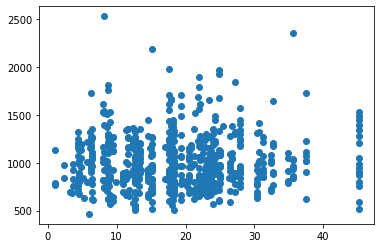

In [63]:
# Crime aginst price after transformation
plt.scatter(df_copy.rt_crime, df_copy.rt_p)

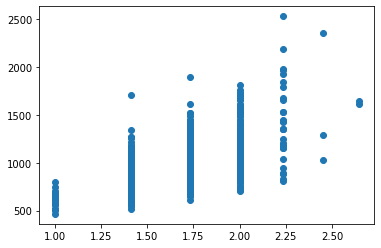

In [64]:
# Number of rooms aginst price after transformation
plt.scatter(df_copy.rt_rooms, df_copy.rt_p)

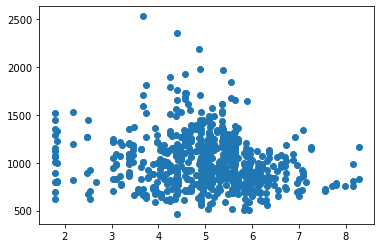

In [65]:
# Time aginst price after transformation
plt.scatter(df_copy.rt_time, df_copy.rt_p)

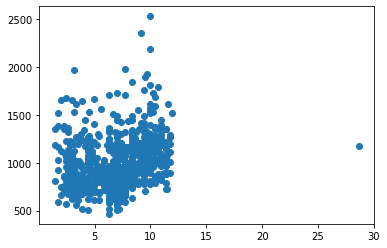

In [66]:
# Age aginst price after transformation
plt.scatter(df_copy.rt_age, df_copy.rt_p)

From the above visualization, it cannot be observed any significant effect on the relationships between estimators and output except for the graph between number of rooms (rooted) and price (rooted). 

Root transformation perhaps might not be the best transformation method to apply for the rest of the estimators except for the rooms attribute.

-------------------------------------

<div class="alert alert-block alert-warning">

## 4.2.2. Power transformation <a class="anchor" name="sq"></a>
    
</div>

The power transformation aims for the same objective: a linear relation between the estimator and output. However, instead of taking root, the dataset will take a power up approach (square power in this example).

In [67]:
# Get estimators and output
df_copy = df[["crime_C_average", "Rooms", "travel_min_to_CBD", "Age", "Price"]]

df_copy["sq_crime"] = None
df_copy["sq_rooms"] = None
df_copy["sq_time"] = None
df_copy["sq_age"] = None
df_copy["sq_p"] = None
i = 0
for row in df_copy.iterrows():
  df_copy["sq_crime"].at[i] = math.pow(df_copy["crime_C_average"][i], 2)
  df_copy["sq_rooms"].at[i] = math.pow(df_copy["Rooms"][i], 2)
  df_copy["sq_time"].at[i] = math.pow(df_copy["travel_min_to_CBD"][i], 2)
  df_copy["sq_age"].at[i] = math.pow(df_copy["Age"][i], 2)
  df_copy["sq_p"].at[i] = math.pow(df_copy["Price"][i], 2)
  i += 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

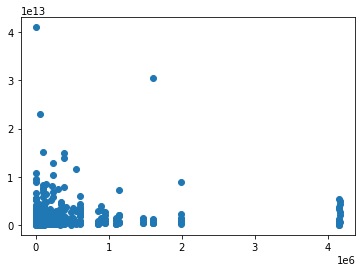

In [68]:
# Squared crime aginst price after transformation
plt.scatter(df_copy.sq_crime, df_copy.sq_p)

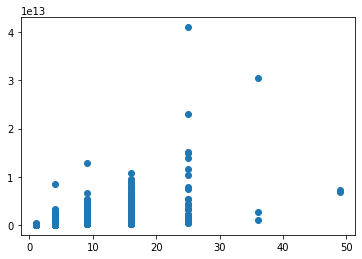

In [69]:
# Squared room aginst price after transformation
plt.scatter(df_copy.sq_rooms, df_copy.sq_p)

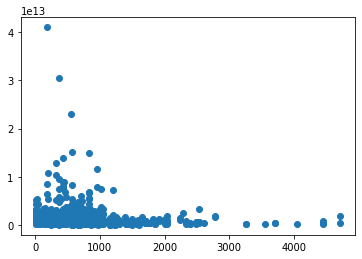

In [70]:
# Squared time aginst price after transformation
plt.scatter(df_copy.sq_time, df_copy.sq_p)

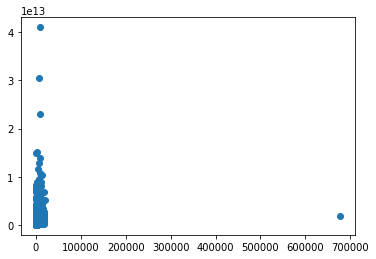

In [71]:
# Squared age aginst price after transformation

plt.scatter(df_copy.sq_age, df_copy.sq_p)


The effect is still unclear, but improvements are shown for some of the estimators when compared to the first data transformation method. 

After applying square power transformation, data appeared to have a clearer relationship between the estimator and the output (eg. higher travel time to CBD, relatively lower price, higher number of crime, lower price, and more rooms, higher the price). 

For the "Age" estimator, although there is no clear trend shown in the visualization, it helps to eliminated one outliers in the dataset that seems to appear in the first transformation method.

-------------------------------------

<div class="alert alert-block alert-warning">

## 4.2.3. Log transformation
<a class="anchor" name="log"></a>
    
</div>

With the same object, the log transformation takes log of the entire dataset.

In [72]:
df_copy = df[["crime_C_average", "Rooms", "travel_min_to_CBD", "Age", "Price"]]
df_copy["ln_crime"] = None
df_copy["ln_rooms"] = None
df_copy["ln_time"] = None
df_copy["ln_age"] = None
df_copy["ln_p"] = None
i = 0
for row in df_copy.iterrows():
  df_copy["ln_crime"].at[i] = math.log(df_copy["crime_C_average"][i])
  df_copy["ln_rooms"].at[i] = math.log(df_copy["Rooms"][i])
  df_copy["ln_time"].at[i] = math.log(df_copy["travel_min_to_CBD"][i])
  df_copy["ln_age"].at[i] = math.log(df_copy["Age"][i])
  df_copy["ln_p"].at[i] = math.log(df_copy["Price"][i])
  i += 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

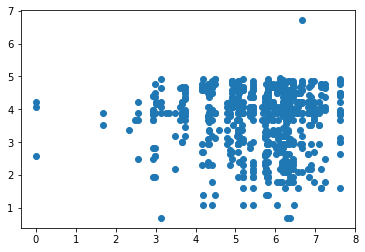

In [73]:
# log crime aginst price after transformation
plt.scatter(df_copy.ln_crime, df_copy.ln_age)

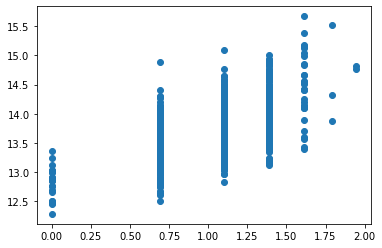

In [74]:
# log room aginst price after transformation

plt.scatter(df_copy.ln_rooms, df_copy.ln_p)

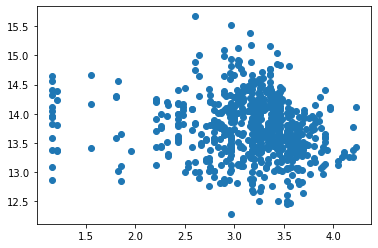

In [75]:
# log time aginst price after transformation

plt.scatter(df_copy.ln_time, df_copy.ln_p)

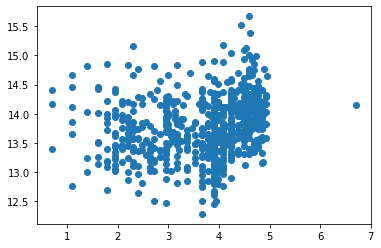

In [76]:
# log age aginst price after transformation

plt.scatter(df_copy.ln_age, df_copy.ln_p)

From the visualizations, the result is similar to the first root transformation performed. There are no evidence showing strong relation between the estimator and output after the log transformation here. Log transformation might not be the best method to apply here.

-------------------------------------

<div class="alert alert-block alert-warning">

## 4.3. Conclusion <a class="anchor" name="conclude"></a>
    
</div>

To conclude, for the given dataset, if only one transformation method will be performed, the power transformation seems to be the better choice among the three.

Firstly, it convert most of the data of estimator to output relatively well. Although the relationship is not linear, it is able to show a weak trend between estimators and the output.

Secondly, it is able to convert outlier in "Age" attribute into a normal data point among the graph. The estimator "Age" failed to show trends when plooted against output "price" in all three of the transformation practice. It is likely that it does not have strong relationship with price at all. If the outlier value eliminated, the situation could be better evaluated and it could bring postive result to the model.

On the other hand, if more than one method could be applied to each estimator and output, I would apply the power transformation to "crime_C_average", "travel_time_to_CBD", and "Age".

As for "Rooms" estimator, due to the unique characteristic that it is the only discrete data here (while the rest are continuous data), the power transformation failed to give "Room" and "Price" the best fit. For room, the root transformation shows better relation between itself and the "price" output.
